<a href="https://colab.research.google.com/github/Josh-Em/canadian-mp-database/blob/main/MP_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🛠️ Python Environment Setup with Libraries
Install essential Python libraries: requests, BeautifulSoup, and OpenAI, for web scraping and API tasks.

In [2]:
!pip install beautifulsoup4 requests
!pip install openai

### 🤖 API Client Initialization with Python
Import and set up requests, BeautifulSoup, Pandas, and OpenAI libraries to enable web scraping and OpenAI API usage.

In [12]:
import requests
from bs4 import BeautifulSoup
import re
from openai import OpenAI
import pandas as pd

api_key = "YOUR_API_KEY_HERE"

client = OpenAI(api_key=api_key)

### 📂 Loading Data from CSV Files
Create a function to safely read CSV files into a pandas DataFrame. This function includes error handling to manage missing files and other potential issues while reading data.

In [4]:
def read_csv_to_dataframe(file_name, **kwargs):
    """
    Reads a CSV file into a pandas DataFrame.

    Parameters:
    file_name (str): Name of the CSV file including extension
    **kwargs: Additional arguments to pass to pd.read_csv()

    Returns:
    pandas.DataFrame: DataFrame containing the CSV data
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_name, **kwargs)
        print(f"Successfully read {file_name}")
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found")
        return None
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

### 📊 Loading and Viewing the MP Dataset
Load the MP (Member of Parliament) data from the CSV file from this page,

https://www.ourcommons.ca/members/en/search

and display basic information about the dataset, including its size and a preview of the first few rows. You must rename the file as mp_data.csv after you upload it to the Collab Notebook

In [5]:
df = read_csv_to_dataframe('mp_data.csv')
if df is not None:
    print("Shape of DataFrame:", df.shape)
    print("\nFirst few rows:")
    print(df.head())

processed_df = read_csv_to_dataframe('mp_data_complete.csv')


Successfully read mp_data.csv
Shape of DataFrame: (336, 8)

First few rows:
  Honorific Title First Name  Last Name                         Constituency  \
0             NaN       Ziad  Aboultaif                     Edmonton Manning   
1             NaN      Scott  Aitchison                  Parry Sound—Muskoka   
2             NaN        Dan      Albas  Central Okanagan—Similkameen—Nicola   
3            Hon.       Omar   Alghabra                   Mississauga Centre   
4             NaN    Shafqat        Ali                      Brampton Centre   

  Province / Territory Political Affiliation                Start Date  \
0              Alberta          Conservative  2021-09-20 12:00:00 a.m.   
1              Ontario          Conservative  2021-09-20 12:00:00 a.m.   
2     British Columbia          Conservative  2021-09-20 12:00:00 a.m.   
3              Ontario               Liberal  2021-09-20 12:00:00 a.m.   
4              Ontario               Liberal  2021-09-20 12:00:00 a.m.   

### 🔗 Creating Wikipedia URLs for MPs
Create a function that generates Wikipedia URLs for each MP by combining their first and last names. The function handles special characters and spaces, ensuring valid URL formation.


In [6]:
import urllib.parse

def create_wikipedia_urls(df):
    """
    Creates a new column 'Wikipedia_URL' with formatted Wikipedia URLs based on first and last names,
    with proper handling of special characters.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'First Name' and 'Last Name' columns

    Returns:
    pandas.DataFrame: DataFrame with new 'Wikipedia_URL' column
    """
    try:
        # Create a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()

        # Create the base names by combining first and last names
        df_copy['Wikipedia_URL'] = df_copy['First Name'].str.strip() + '_' + \
                                 df_copy['Last Name'].str.strip()

        # Replace spaces with underscores
        df_copy['Wikipedia_URL'] = df_copy['Wikipedia_URL'].str.replace(' ', '_')

        # URL encode the names (this will handle special characters)
        df_copy['Wikipedia_URL'] = df_copy['Wikipedia_URL'].apply(lambda x: urllib.parse.quote(x))

        # Add the Wikipedia prefix
        df_copy['Wikipedia_URL'] = 'https://en.wikipedia.org/wiki/' + df_copy['Wikipedia_URL']

        print("Successfully created Wikipedia URLs")
        return df_copy

    except Exception as e:
        print(f"Error creating Wikipedia URLs: {str(e)}")
        return None

# Example usage:
# df = create_wikipedia_urls(df)
# print(df['Wikipedia_URL'].head())

### 🔗 Update Wikipedia URLs for Ambiguous  MPs
Create a function that checks if a URL is in a dictionary of the form

```
{ incorrect_url : correct_url }
```
and if so then replace its URL with the corrected version. This handles MPs which require a _(politician), _(Canadian_politician), etc. suffix





In [7]:
def update_wikipedia_urls(df, corrections_dict):
    """
    Updates Wikipedia URLs in the DataFrame based on a corrections dictionary.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Wikipedia_URL' column
    corrections_dict (dict): Dictionary with incorrect URLs as keys and correct URLs as values

    Returns:
    pandas.DataFrame: DataFrame with updated Wikipedia URLs
    """
    try:
        # Create a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()

        # Counter for tracking number of corrections made
        corrections_count = 0

        # Loop through each row in the DataFrame
        for index, row in df_copy.iterrows():
            current_url = row['Wikipedia_URL']

            # Check if the current URL is in our corrections dictionary
            if current_url in corrections_dict:
                # Update the URL with the correct version
                df_copy.at[index, 'Wikipedia_URL'] = corrections_dict[current_url]
                corrections_count += 1

        print(f"Successfully updated {corrections_count} Wikipedia URLs")
        return df_copy

    except Exception as e:
        print(f"Error updating Wikipedia URLs: {str(e)}")
        return None

# Example usage:
corrections = {
  "https://en.wikipedia.org/wiki/Adam_Chambers" : "https://en.wikipedia.org/wiki/Adam_Chambers_(politician)",
  "https://en.wikipedia.org/wiki/Ben_Carr" : "https://en.wikipedia.org/wiki/Ben_Carr_(politician)",
  "https://en.wikipedia.org/wiki/Robert_Morrissey" : "https://en.wikipedia.org/wiki/Bobby_Morrissey",
  "https://en.wikipedia.org/wiki/Brenda_Shanahan" : "https://en.wikipedia.org/wiki/Brenda_Shanahan_(politician)",
  "https://en.wikipedia.org/wiki/Carol_Hughes" : "https://en.wikipedia.org/wiki/Carol_Hughes_(politician)",
  "https://en.wikipedia.org/wiki/Chad_Collins" : "https://en.wikipedia.org/wiki/Chad_Collins_(politician)",
  "https://en.wikipedia.org/wiki/Chris_Lewis" : "https://en.wikipedia.org/wiki/Chris_Lewis_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Don_Stewart" : "https://en.wikipedia.org/wiki/Don_Stewart_(Ontario_politician)",
  "https://en.wikipedia.org/wiki/Eric_Duncan" : "https://en.wikipedia.org/wiki/Eric_Duncan_(politician)",
  "https://en.wikipedia.org/wiki/Greg_McLean" : "https://en.wikipedia.org/wiki/Greg_McLean_(politician)",
  "https://en.wikipedia.org/wiki/Han_Dong" : "https://en.wikipedia.org/wiki/Han_Dong_(politician)",
  "https://en.wikipedia.org/wiki/Heather_McPherson" : "https://en.wikipedia.org/wiki/Heather_McPherson_(politician)",
  "https://en.wikipedia.org/wiki/Marc_Miller" : "https://en.wikipedia.org/wiki/Heather_McPherson_(politician)",
  "https://en.wikipedia.org/wiki/Jake_Stewart" : "https://en.wikipedia.org/wiki/Jake_Stewart_(politician)",
  "https://en.wikipedia.org/wiki/James_Maloney" : "https://en.wikipedia.org/wiki/James_Maloney_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Joanne_Thompson" : "https://en.wikipedia.org/wiki/Joanne_Thompson_(politician)",
  "https://en.wikipedia.org/wiki/John_McKay" : "https://en.wikipedia.org/wiki/John_McKay_(politician)",
  "https://en.wikipedia.org/wiki/John_Williamson" : "https://en.wikipedia.org/wiki/John_Williamson_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Judy_A._Sgro" : "https://en.wikipedia.org/wiki/Judy_Sgro",
  "https://en.wikipedia.org/wiki/Ken_McDonald" : "https://en.wikipedia.org/wiki/Ken_McDonald_(politician)",
  "https://en.wikipedia.org/wiki/Matthew_Green" : "https://en.wikipedia.org/wiki/Matthew_Green_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Michael_Barrett" : "https://en.wikipedia.org/wiki/Michael_Barrett_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Michael_Cooper" : "https://en.wikipedia.org/wiki/Michael_Cooper_(politician)",
  "https://en.wikipedia.org/wiki/Michael_McLeod" : "https://en.wikipedia.org/wiki/Michael_McLeod_(politician)",
  "https://en.wikipedia.org/wiki/Mike_Lake" : "https://en.wikipedia.org/wiki/Mike_Lake_(politician)",
  "https://en.wikipedia.org/wiki/Pablo_Rodriguez" : "https://en.wikipedia.org/wiki/Pablo_Rodriguez_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Pat_Kelly" : "https://en.wikipedia.org/wiki/Pat_Kelly_(politician)",
  "https://en.wikipedia.org/wiki/Paul_Chiang" : "https://en.wikipedia.org/wiki/Paul_Chiang_(politician)",
  "https://en.wikipedia.org/wiki/Philip_Lawrence" : "https://en.wikipedia.org/wiki/Philip_Lawrence_(politician)",
  "https://en.wikipedia.org/wiki/Richard_Cannings" : "https://en.wikipedia.org/wiki/Richard_Cannings_(British_Columbia_politician)",
  "https://en.wikipedia.org/wiki/Rob_Moore" : "https://en.wikipedia.org/wiki/Rob_Moore_(politician)",
  "https://en.wikipedia.org/wiki/Rob_Morrison" : "https://en.wikipedia.org/wiki/Rob_Morrison_(politician)",
  "https://en.wikipedia.org/wiki/Robert_Oliphant" : "https://en.wikipedia.org/wiki/Rob_Oliphant",
  "https://en.wikipedia.org/wiki/Ryan_Turnbull" : "https://en.wikipedia.org/wiki/Ryan_Turnbull_(politician)",
  "https://en.wikipedia.org/wiki/Ryan_Williams" : "https://en.wikipedia.org/wiki/Ryan_Williams_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Scott_Reid" : "https://en.wikipedia.org/wiki/Scott_Reid_(politician)",
  "https://en.wikipedia.org/wiki/Sean_Casey" : "https://en.wikipedia.org/wiki/Sean_Casey_(Canadian_politician)",
  "https://en.wikipedia.org/wiki/Sean_Fraser" : "https://en.wikipedia.org/wiki/Sean_Fraser_(politician)",
  "https://en.wikipedia.org/wiki/Shaun_Chen" : "https://en.wikipedia.org/wiki/Shaun_Chen_(politician)",
  "https://en.wikipedia.org/wiki/Stephen_Ellis" : "https://en.wikipedia.org/wiki/Stephen_Ellis_(politician)",
  "https://en.wikipedia.org/wiki/Tim_Louis" : "https://en.wikipedia.org/wiki/Tim_Louis_(Ontario_politician)"
}
# df_updated = update_wikipedia_urls(df, corrections)

### 👁️ Displaying Generated Wikipedia URLs
Apply the URL creation function to our DataFrame and configure the display settings to show the complete URLs. Show a preview of the first 50 MPs with their names and corresponding Wikipedia links.

In [8]:
# Apply the function to your DataFrame
df = create_wikipedia_urls(df)
df = update_wikipedia_urls(df, corrections)

# Set display options to show full URLsa
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Auto-adjust display width

# Display the first few rows of the new column
if df is not None:
    print("\nFirst few Wikipedia URLs:")
    print(df[['First Name', 'Last Name', 'Wikipedia_URL']].head(50))

Successfully created Wikipedia URLs
Successfully updated 40 Wikipedia URLs

First few Wikipedia URLs:
       First Name          Last Name  \
0            Ziad          Aboultaif   
1           Scott          Aitchison   
2             Dan              Albas   
3            Omar           Alghabra   
4         Shafqat                Ali   
5            Dean            Allison   
6           Anita              Anand   
7            Gary     Anandasangaree   
8         Charlie              Angus   
9             Mel             Arnold   
10           René         Arseneault   
11        Chandra               Arya   
12           Niki             Ashton   
13         Jenica              Atwin   
14         Taylor           Bachrach   
15          Vance            Badawey   
16           Parm              Bains   
17           Yvan              Baker   
18           Tony         Baldinelli   
19           John             Barlow   
20        Michael            Barrett   
21     Lisa Marie 

### 🌐 Wikipedia Content Scraping Function
Create a function to extract and clean text content from Wikipedia pages. This function handles webpage retrieval, HTML parsing, and text cleaning to provide readable content without references or unwanted elements.

In [9]:
import requests
from bs4 import BeautifulSoup
import re

def scrape_wikipedia(url):
    """
    Scrapes text content from a Wikipedia page.

    Args:
        url (str): URL of the Wikipedia page to scrape

    Returns:
        str: The main text content of the Wikipedia page

    Raises:
        ValueError: If the URL is not a valid Wikipedia page
        requests.RequestException: If there's an error retrieving the page
    """
    # Verify it's a Wikipedia URL
    if not url.startswith('https://en.wikipedia.org/wiki/'):
        raise ValueError("URL must be a valid English Wikipedia page")

    try:
        # Send GET request to the URL
        response = requests.get(url)
        response.raise_for_status()

        # Create BeautifulSoup object to parse HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Remove unwanted elements
        for element in soup.find_all(['script', 'style', 'sup']):
            element.decompose()

        # Get the main content div
        content = soup.find(id='mw-content-text')
        if not content:
            raise ValueError("Could not find main content section")

        # Get all text from the main content
        text = content.get_text(separator=' ')

        # Clean up the text
        text = re.sub(r'\[\d+\]', '', text)  # Remove reference numbers
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
        text = text.strip()

        return text

    except requests.RequestException as e:
        raise requests.RequestException(f"Error retrieving the page: {str(e)}")
    except Exception as e:
        raise Exception(f"An error occurred: {str(e)}")

url = "https://en.wikipedia.org/wiki/Pierre_Poilievre"
text = scrape_wikipedia(url)
print(text)

Canadian politician (born 1979) "Poilievre" redirects here. For other uses, see Poilievre (disambiguation) . The Honourable Pierre Poilievre PC MP Poilievre in 2023 Leader of the Opposition Incumbent Assumed office September 10, 2022 Monarch Charles III Prime Minister Justin Trudeau Deputy Melissa Lantsman Tim Uppal Preceded by Candice Bergen Leader of the Conservative Party Incumbent Assumed office September 10, 2022 Deputy Melissa Lantsman Tim Uppal Preceded by Candice Bergen (interim) Minister of Employment and Social Development In office February 9, 2015 – November 4, 2015 Prime Minister Stephen Harper Preceded by Jason Kenney Succeeded by Jean-Yves Duclos (Families, Children and Social Development) MaryAnn Mihychuk (Employment, Workforce Development and Labour) Minister for Democratic Reform In office July 15, 2013 – November 4, 2015 Prime Minister Stephen Harper Preceded by Tim Uppal Succeeded by Maryam Monsef (Democratic Institutions) Shadow Minister 2021–2022 Finance Feb–Nov 2

### 🤖 AI-Powered MP Information Extraction
Create a function that uses GPT-4o to analyze Wikipedia text and extract structured information about Members of Parliament. The function organizes details about their basic information, education, career, policy positions, and controversial statements into a JSON format.

In [10]:
def get_mp_info(wiki_text):
  response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": "Extract detailed information from a Wikipedia article on a Canadian Member of Parliament and organize it in a structured format.\n\nInclude the following sections:\n\n- BASIC INFORMATION\n  - Full Name\n  - Years Active in Politics (Integer Number)\n  - Current House of Commons Position (Minister, Leader, Speaker, etc.)\n\n- EDUCATION\n  - Schools/Universities attended (can be multiple)\n  - Subjects studied (can be multiple)\n  - Level of Education (e.g., high school, bachelor's, master's, doctorate)\n\n- CAREER\n  - Jobs before entering politics (can be multiple)\n  - Parents' occupations (can be multiple)\n\n- SIGNATURE POLICY POSITIONS\n  - Up to five notable policy stances, votes, or campaign positions that define their political career (can be multiple)\n\n- CONTROVERSIAL STATEMENTS\n  - Notable controversial views or statements (can be multiple)\n\n# Output Format\n\nProvide the extracted information in a structured JSON format:\n\n```json\n{\n  \"basic_information\": {\n    \"full_name\": \"[Full Name]\",\n    \"years_active_in_politics\": [Integer],\n    \"current_house_of_commons_position\": \"[Position]\"\n  },\n  \"education\": {\n    \"schools_universities_attended\": [\"[School 1]\", \"[School 2]\"],\n    \"subjects_studied\": [\"[Subject 1]\", \"[Subject 2]\"],\n    \"level_of_education\": \"[Level]\"\n  },\n  \"career\": {\n    \"jobs_before_entering_politics\": [\"[Job 1]\", \"[Job 2]\"],\n    \"parents_occupations\": [\"[Occupation 1]\", \"[Occupation 2]\"]\n  },\n  \"signature_policy_positions\": [\n    \"[Policy Position 1]\",\n    \"[Policy Position 2]\",\n    \"[Policy Position 3]\",\n    \"[Policy Position 4]\",\n    \"[Policy Position 5]\"\n  ],\n  \"controversial_statements\": [\n    \"[Statement 1]\",\n    \"[Statement 2]\"\n  ]\n}\n```\n\n# Notes\n\n- Ensure all relevant information extracted is relevant and accurate.\n- Please note the information might not fully populate all sections if it is not available in the article.\n- If certain information is unavailable, use empty placeholders (e.g., \"[]\")."
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": wiki_text
          }
        ]
      }
    ],
    response_format={
      "type": "json_object"
    },
    temperature=1,
    max_completion_tokens=2048,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  return response.choices[0].message.content

url = "https://en.wikipedia.org/wiki/Pierre_Poilievre"
wiki_text = scrape_wikipedia(url)
info = get_mp_info(wiki_text)
print(info)

{
  "basic_information": {
    "full_name": "Pierre Marcel Poilievre",
    "years_active_in_politics": 19,
    "current_house_of_commons_position": "Leader of the Opposition"
  },
  "education": {
    "schools_universities_attended": ["University of Calgary"],
    "subjects_studied": ["International Relations"],
    "level_of_education": "Bachelor's"
  },
  "career": {
    "jobs_before_entering_politics": ["Corporate collections at Telus", "Journalist for Alberta Report", "Political advisor for Stockwell Day"],
    "parents_occupations": ["Schoolteachers"]
  },
  "signature_policy_positions": [
    "Support for Pay-as-you-go law to balance new government spending with cuts",
    "Advocacy for normalizing cryptocurrencies like Bitcoin",
    "Criticism of Bank of Canada's monetary policies and proposal to audit it",
    "Opposition to Liberal government's carbon tax",
    "Support for expedited professional licensing for immigrants"
  ],
  "controversial_statements": [
    "Criticism of 

### 📋 Converting MP Data to Structured Format
Convert the detailed MP information from JSON format into a clean, readable table (DataFrame). This makes it easier to view and work with information such as education, career history, and political positions for each Member of Parliament.


In [11]:
import pandas as pd
import json

def parse_mp_info_to_df(info_json, url):
    """
    Parses MP information JSON and converts it to a DataFrame row.

    Parameters:
    info_json (str or dict): JSON string or dictionary containing MP information
    url (str): Wikipedia URL for the MP

    Returns:
    pandas.DataFrame: DataFrame containing the parsed information
    """
    try:
        # Convert string to dict if necessary
        if isinstance(info_json, str):
            info_dict = json.loads(info_json)
        else:
            info_dict = info_json

        # Flatten the nested dictionary
        flat_dict = {
            'wikipedia_url': url,
            'full_name': info_dict['basic_information']['full_name'],
            'years_active_in_politics': info_dict['basic_information']['years_active_in_politics'],
            'current_house_position': info_dict['basic_information']['current_house_of_commons_position'],

            # Join list items with semicolons for better readability
            'schools_attended': '; '.join(info_dict['education']['schools_universities_attended']),
            'subjects_studied': '; '.join(info_dict['education']['subjects_studied']),
            'level_of_education': info_dict['education']['level_of_education'],

            'previous_jobs': '; '.join(info_dict['career']['jobs_before_entering_politics']),
            'parents_occupations': '; '.join(info_dict['career']['parents_occupations']),

            'policy_positions': '; '.join(info_dict['signature_policy_positions']),
            'controversial_statements': '; '.join(info_dict['controversial_statements'])
        }

        # Create DataFrame from the flattened dictionary
        df = pd.DataFrame([flat_dict])

        print("Successfully parsed MP information")
        return df

    except Exception as e:
        print(f"Error parsing MP information: {str(e)}")
        return None

# Example usage:
url = "https://en.wikipedia.org/wiki/Pierre_Poilievre"
wiki_text = scrape_wikipedia(url)
info = get_mp_info(wiki_text)
df_test = parse_mp_info_to_df(info, url)

if df_test is not None:
    pd.set_option('display.max_colwidth', None)
    print("\nParsed MP Information:")
    print(df_test)

Successfully parsed MP information

Parsed MP Information:
                                    wikipedia_url                full_name  \
0  https://en.wikipedia.org/wiki/Pierre_Poilievre  Pierre Marcel Poilievre   

   years_active_in_politics    current_house_position       schools_attended  \
0                        20  Leader of the Opposition  University of Calgary   

          subjects_studied level_of_education  \
0  International Relations         Bachelor's   

                                                                                        previous_jobs  \
0  Paperboy; Corporate collections at Telus; Journalist for Alberta Report; Advisor for Stockwell Day   

  parents_occupations  \
0      Schoolteachers   

                                                                                                                                                                                                                     policy_positions  \
0  Campaigns on economic issu

### 💾 Saving MP Data to File
Create a function to save our MP information table to a CSV file that can be opened in Excel or other spreadsheet programs. Includes a complete example of gathering, processing, and saving information about an MP.

In [ ]:
def save_df_to_csv(df, filename, index=False):
    """
    Saves a DataFrame to a CSV file.

    Parameters:
    df (pandas.DataFrame): DataFrame to save
    filename (str): Name of the file to save (including .csv extension)
    index (bool): Whether to include the index in the CSV file (default: False)

    Returns:
    None
    """
    try:
        df.to_csv(filename, index=index, encoding='utf-8')
        print(f"Successfully saved DataFrame to {filename}")
    except Exception as e:
        print(f"Error saving DataFrame to CSV: {str(e)}")

# Complete pipeline example:
url = "https://en.wikipedia.org/wiki/Pierre_Poilievre"
wiki_text = scrape_wikipedia(url)
info = get_mp_info(wiki_text)
df_test = parse_mp_info_to_df(info, url)

if df_test is not None:
    # Save to CSV
    save_df_to_csv(df_test, 'mp_info_test.csv')

Successfully parsed MP information
Successfully saved DataFrame to mp_info_test.csv


### 🎯 Running the Complete MP Research Pipeline
This is our main function that brings together all the previous steps into one automated process:
1. Takes our list of MPs
2. Visits each MP's Wikipedia page
3. Extracts and processes their information
4. Organizes everything into a clean table
5. Saves the results regularly as backup

In [ ]:
import pandas as pd
import time
from tqdm import tqdm

def process_mp_data(input_df, save_frequency=20, output_file='mp_data_processed.csv'):
    """
    Process MP data from Wikipedia URLs and combine with existing DataFrame.
    """
    print(f"\nInitializing processing of {len(input_df)} MPs...")
    print(f"Will save backup every {save_frequency} MPs to {output_file}")

    # Create a copy of the input DataFrame
    result_df = input_df.copy()
    print("\nCreated copy of input DataFrame")

    # Initialize new columns
    new_columns = ['full_name', 'years_active_in_politics', 'current_house_position',
                  'schools_attended', 'subjects_studied', 'level_of_education',
                  'previous_jobs', 'parents_occupations', 'policy_positions',
                  'controversial_statements']

    for col in new_columns:
        result_df[col] = None
    print(f"Initialized {len(new_columns)} new columns for MP information")

    # Track processing errors
    errors = []
    successful_processes = 0

    # Process each MP
    print("\nStarting MP processing loop...")
    for index, row in tqdm(result_df.iterrows(), total=len(result_df)):
        print(f"\n{'='*80}")
        print(f"Processing MP {index + 1}/{len(result_df)}")
        print(f"Current MP: {row['First Name']} {row['Last Name']}")

        try:
            # Get Wikipedia URL
            wiki_url = row['Wikipedia_URL']
            print(f"Processing URL: {wiki_url}")

            # Scrape Wikipedia text
            print("Scraping Wikipedia text...")
            wiki_text = scrape_wikipedia(wiki_url)

            # Skip if no text was scraped
            if not wiki_text:
                print(f"WARNING: No text scraped for {wiki_url}")
                errors.append((wiki_url, "No text scraped"))
                continue
            print(f"Successfully scraped {len(wiki_text)} characters of text")

            # Get MP info from GPT
            print("Sending text to GPT for information extraction...")
            info = get_mp_info(wiki_text)
            print("Received response from GPT")

            # Parse the information
            print("Parsing GPT response into DataFrame format...")
            parsed_df = parse_mp_info_to_df(info, wiki_url)

            if parsed_df is not None:
                print("Successfully parsed information")
                # Update the result DataFrame with the new information
                for col in new_columns:
                    result_df.at[index, col] = parsed_df.iloc[0][col]
                successful_processes += 1

            # Save periodically
            if (index + 1) % save_frequency == 0:
                print(f"\nReached save checkpoint ({index + 1} MPs processed)")
                save_df_to_csv(result_df, f'backup_{output_file}')
                print(f"Progress summary:")
                print(f"- Successfully processed: {successful_processes}")
                print(f"- Errors encountered: {len(errors)}")
                print(f"- Completion rate: {(successful_processes/(index+1))*100:.2f}%")

            # Add a small delay to avoid overwhelming the API
            print("Adding brief delay before next MP...")
            time.sleep(1)

        except Exception as e:
            print(f"\nERROR processing {wiki_url}")
            print(f"Error details: {str(e)}")
            errors.append((wiki_url, str(e)))
            continue

    # Save the final results
    print("\nProcessing complete! Saving final results...")
    save_df_to_csv(result_df, output_file)

    # Save error log if there were any errors
    if errors:
        print(f"\nSaving error log... ({len(errors)} errors encountered)")
        error_df = pd.DataFrame(errors, columns=['URL', 'Error'])
        save_df_to_csv(error_df, 'processing_errors.csv')

    # Print final summary
    print("\nFinal Processing Summary:")
    print(f"Total MPs processed: {len(input_df)}")
    print(f"Successful processes: {successful_processes}")
    print(f"Failed processes: {len(errors)}")
    print(f"Success rate: {(successful_processes/len(input_df))*100:.2f}%")
    print(f"Results saved to: {output_file}")
    if errors:
        print(f"Error log saved to: processing_errors.csv")

    return result_df

# # Example usage:
print("Starting MP data processing pipeline...")
processed_df = process_mp_data(
    input_df=df,
    save_frequency=5,
    output_file='mp_data_complete.csv'
)

# Display results
if processed_df is not None:
    print("\nDisplaying first few rows of processed data:")
    pd.set_option('display.max_colwidth', None)
    print(processed_df.head())

### 🔍 Finding and Fixing Missing MP Data
A cleanup function that identifies MPs with missing information and attempts to collect their data again. This ensures our database is as complete as possible.

In [ ]:
def find_and_reprocess_missing_mps(processed_df, save_frequency=10, output_file='mp_data_complete_updated.csv'):
    """
    Find MPs with missing information and reprocess them.

    Parameters:
    processed_df (pandas.DataFrame): Previously processed DataFrame
    save_frequency (int): How often to save the results
    output_file (str): Name of the output CSV file

    Returns:
    pandas.DataFrame: Updated DataFrame with reprocessed information
    """
    # Find MPs with missing full_name
    missing_mps = processed_df[processed_df['full_name'].isna()].copy()

    print(f"\nFound {len(missing_mps)} MPs with missing information:")
    print("\nMPs to be reprocessed:")
    for idx, row in missing_mps.iterrows():
        print(f"- {row['First Name']} {row['Last Name']}: {row['Wikipedia_URL']}")

    if len(missing_mps) == 0:
        print("No MPs need reprocessing!")
        return processed_df

    # Confirm before proceeding
    proceed = input("\nDo you want to proceed with reprocessing these MPs? (yes/no): ")
    if proceed.lower() != 'yes':
        print("Reprocessing cancelled.")
        return processed_df

    # Create a copy of the original DataFrame for updating
    result_df = processed_df.copy()
    errors = []
    successful_reprocesses = 0

    print("\nStarting reprocessing of missing MPs...")
    for index, row in tqdm(missing_mps.iterrows(), total=len(missing_mps)):
        print(f"\n{'='*80}")
        print(f"Reprocessing MP: {row['First Name']} {row['Last Name']}")

        try:
            # Get Wikipedia URL
            wiki_url = row['Wikipedia_URL']
            print(f"Processing URL: {wiki_url}")

            # Scrape Wikipedia text
            print("Scraping Wikipedia text...")
            wiki_text = scrape_wikipedia(wiki_url)

            if not wiki_text:
                print(f"WARNING: No text scraped for {wiki_url}")
                errors.append((wiki_url, "No text scraped"))
                continue

            print(f"Successfully scraped {len(wiki_text)} characters of text")

            # Get MP info from GPT
            print("Sending text to GPT for information extraction...")
            info = get_mp_info(wiki_text)

            # Parse the information
            print("Parsing GPT response...")
            parsed_df = parse_mp_info_to_df(info, wiki_url)

            if parsed_df is not None:
                # Update the result DataFrame with the new information
                for col in parsed_df.columns:
                    if col in result_df.columns and col != 'wikipedia_url':
                        result_df.at[index, col] = parsed_df.iloc[0][col]
                successful_reprocesses += 1
                print("Successfully updated information")

            # Save periodically
            if successful_reprocesses % save_frequency == 0:
                print(f"\nSaving backup after {successful_reprocesses} reprocessed MPs...")
                save_df_to_csv(result_df, f'backup_reprocess_{output_file}')

            time.sleep(1)  # Brief delay

        except Exception as e:
            print(f"\nERROR reprocessing {wiki_url}")
            print(f"Error details: {str(e)}")
            errors.append((wiki_url, str(e)))
            continue

    # Save final results
    print("\nReprocessing complete! Saving final results...")
    save_df_to_csv(result_df, output_file)

    # Save error log if there were any errors
    if errors:
        print(f"\nSaving error log... ({len(errors)} errors encountered)")
        error_df = pd.DataFrame(errors, columns=['URL', 'Error'])
        save_df_to_csv(error_df, 'reprocessing_errors.csv')

    # Print final summary
    print("\nReprocessing Summary:")
    print(f"Total MPs attempted to reprocess: {len(missing_mps)}")
    print(f"Successfully reprocessed: {successful_reprocesses}")
    print(f"Failed to reprocess: {len(errors)}")
    print(f"Success rate: {(successful_reprocesses/len(missing_mps))*100:.2f}%")
    print(f"Updated results saved to: {output_file}")

    return result_df

# Example usage:
# First, load your previously processed DataFrame
# processed_df = pd.read_csv('mp_data_complete.csv')

# Then run the reprocessing
updated_df = find_and_reprocess_missing_mps(
    processed_df=processed_df,
    save_frequency=10,
    output_file='mp_data_complete_updated.csv'
)

# Check if there are still any missing entries
remaining_missing = updated_df[updated_df['full_name'].isna()]
if len(remaining_missing) > 0:
    print("\nRemaining MPs with missing information:")
    for idx, row in remaining_missing.iterrows():
        print(f"- {row['First Name']} {row['Last Name']}")
else:
    print("\nAll MPs have been successfully processed!")


Found 10 MPs with missing information:

MPs to be reprocessed:
- Terry Beech: https://en.wikipedia.org/wiki/Terry_Beech
- Michelle Ferreri: https://en.wikipedia.org/wiki/Michelle_Ferreri
- Mike Kelloway: https://en.wikipedia.org/wiki/Mike_Kelloway
- Mike Lake: https://en.wikipedia.org/wiki/Mike_Lake
- Alistair MacGregor: https://en.wikipedia.org/wiki/Alistair_MacGregor
- Robert Morrissey: https://en.wikipedia.org/wiki/Robert_Morrissey
- Judy A. Sgro: https://en.wikipedia.org/wiki/Judy_A._Sgro
- Francesco Sorbara: https://en.wikipedia.org/wiki/Francesco_Sorbara
- Jake Stewart: https://en.wikipedia.org/wiki/Jake_Stewart
- Kevin Vuong: https://en.wikipedia.org/wiki/Kevin_Vuong

Do you want to proceed with reprocessing these MPs? (yes/no): yes

Starting reprocessing of missing MPs...


  0%|          | 0/10 [00:00<?, ?it/s]


Reprocessing MP: Terry Beech
Processing URL: https://en.wikipedia.org/wiki/Terry_Beech
Scraping Wikipedia text...
Successfully scraped 18705 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 10%|█         | 1/10 [00:10<01:36, 10.72s/it]


Reprocessing MP: Michelle Ferreri
Processing URL: https://en.wikipedia.org/wiki/Michelle_Ferreri
Scraping Wikipedia text...
Successfully scraped 6161 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 20%|██        | 2/10 [00:19<01:18,  9.80s/it]


Reprocessing MP: Mike Kelloway
Processing URL: https://en.wikipedia.org/wiki/Mike_Kelloway
Scraping Wikipedia text...
Successfully scraped 5650 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 30%|███       | 3/10 [00:30<01:11, 10.20s/it]


Reprocessing MP: Mike Lake
Processing URL: https://en.wikipedia.org/wiki/Mike_Lake
Scraping Wikipedia text...
Successfully scraped 813 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 40%|████      | 4/10 [00:34<00:45,  7.55s/it]


Reprocessing MP: Alistair MacGregor
Processing URL: https://en.wikipedia.org/wiki/Alistair_MacGregor
Scraping Wikipedia text...
Successfully scraped 15190 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 60%|██████    | 6/10 [00:42<00:20,  5.20s/it]


Reprocessing MP: Robert Morrissey
Processing URL: https://en.wikipedia.org/wiki/Robert_Morrissey
Scraping Wikipedia text...

ERROR reprocessing https://en.wikipedia.org/wiki/Robert_Morrissey
Error details: Error retrieving the page: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Robert_Morrissey

Reprocessing MP: Judy A. Sgro
Processing URL: https://en.wikipedia.org/wiki/Judy_A._Sgro
Scraping Wikipedia text...


 70%|███████   | 7/10 [00:42<00:10,  3.55s/it]


ERROR reprocessing https://en.wikipedia.org/wiki/Judy_A._Sgro
Error details: Error retrieving the page: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Judy_A._Sgro

Reprocessing MP: Francesco Sorbara
Processing URL: https://en.wikipedia.org/wiki/Francesco_Sorbara
Scraping Wikipedia text...
Successfully scraped 7376 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 80%|████████  | 8/10 [00:48<00:08,  4.39s/it]


Reprocessing MP: Jake Stewart
Processing URL: https://en.wikipedia.org/wiki/Jake_Stewart
Scraping Wikipedia text...
Successfully scraped 385 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


 90%|█████████ | 9/10 [00:51<00:03,  3.96s/it]


Reprocessing MP: Kevin Vuong
Processing URL: https://en.wikipedia.org/wiki/Kevin_Vuong
Scraping Wikipedia text...
Successfully scraped 24894 characters of text
Sending text to GPT for information extraction...
Parsing GPT response...
Successfully parsed MP information
Successfully updated information


100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


Reprocessing complete! Saving final results...
Successfully saved DataFrame to mp_data_complete_updated.csv

Saving error log... (2 errors encountered)
Successfully saved DataFrame to reprocessing_errors.csv

Reprocessing Summary:
Total MPs attempted to reprocess: 10
Successfully reprocessed: 8
Failed to reprocess: 2
Success rate: 80.00%
Updated results saved to: mp_data_complete_updated.csv

Remaining MPs with missing information:
- Robert Morrissey
- Judy A. Sgro


### 📊 Visualizing Top MP Schools
Create a bar chart showing the most common schools attended by Members of Parliament. This helps us understand educational patterns among MPs and identify the most influential educational institutions.

<ipython-input-25-7883ebffb007>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_schools.values, y=top_10_schools.index, palette='viridis')


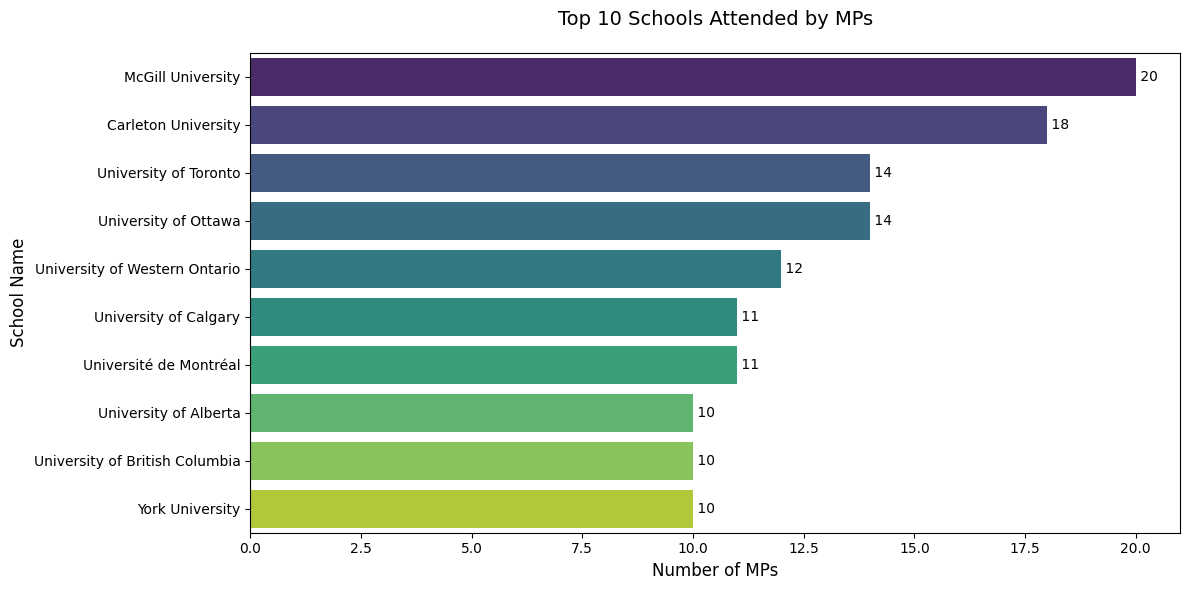


Top 10 Schools (with counts):
McGill University: 20 MPs
Carleton University: 18 MPs
University of Toronto: 14 MPs
University of Ottawa: 14 MPs
University of Western Ontario: 12 MPs
University of Calgary: 11 MPs
Université de Montréal: 11 MPs
University of Alberta: 10 MPs
University of British Columbia: 10 MPs
York University: 10 MPs


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_schools(df, figsize=(12, 6)):
    """
    Create a bar chart of the top 10 schools attended by MPs.

    Parameters:
    df (pandas.DataFrame): DataFrame containing MP information
    figsize (tuple): Figure size (width, height)
    """
    # Create a list of all schools by splitting the semicolon-separated strings
    all_schools = []
    for schools in df['schools_attended'].dropna():
        all_schools.extend([school.strip() for school in schools.split(';')])

    # Count frequency of each school
    school_counts = pd.Series(all_schools).value_counts()

    # Get top 10 schools
    top_10_schools = school_counts.head(10)

    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(x=top_10_schools.values, y=top_10_schools.index, palette='viridis')

    # Customize the plot
    plt.title('Top 10 Schools Attended by MPs', pad=20, fontsize=14)
    plt.xlabel('Number of MPs', fontsize=12)
    plt.ylabel('School Name', fontsize=12)

    # Add value labels on the bars
    for i, v in enumerate(top_10_schools.values):
        plt.text(v, i, f' {v}', va='center')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print the exact numbers
    print("\nTop 10 Schools (with counts):")
    for school, count in top_10_schools.items():
        print(f"{school}: {count} MPs")

# Example usage:
plot_top_schools(updated_df)

### 👔 Visualizing MPs' Career Backgrounds
Create a bar chart showing the most common jobs MPs held before entering politics. This helps us understand the professional backgrounds of our parliamentarians and identify common career paths to politics.

<ipython-input-26-429448127dc6>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_occupations.values, y=top_occupations.index, palette='viridis')


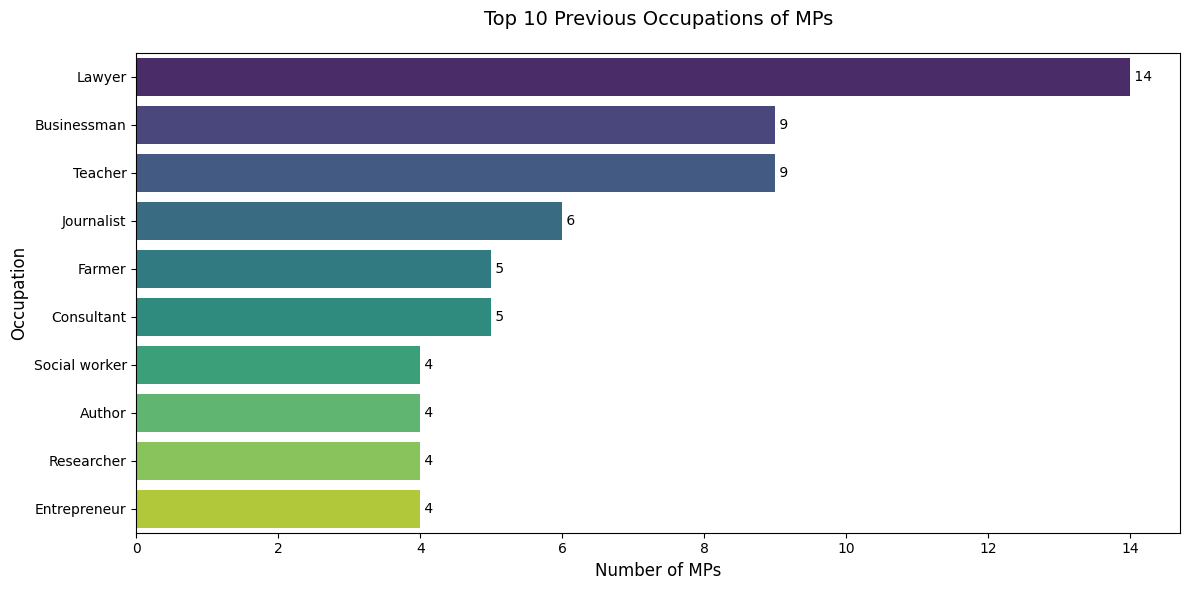


Top 10 Previous Occupations (with counts and percentages):
Lawyer: 14 MPs (4.2%)
Businessman: 9 MPs (2.7%)
Teacher: 9 MPs (2.7%)
Journalist: 6 MPs (1.8%)
Farmer: 5 MPs (1.5%)
Consultant: 5 MPs (1.5%)
Social worker: 4 MPs (1.2%)
Author: 4 MPs (1.2%)
Researcher: 4 MPs (1.2%)
Entrepreneur: 4 MPs (1.2%)

Total unique occupations found: 651


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_occupations(df, top_n=10, figsize=(12, 6)):
    """
    Create a bar chart of the top previous occupations of MPs.

    Parameters:
    df (pandas.DataFrame): DataFrame containing MP information
    top_n (int): Number of top occupations to display
    figsize (tuple): Figure size (width, height)
    """
    # Create a list of all occupations by splitting the semicolon-separated strings
    all_occupations = []
    for occupations in df['previous_jobs'].dropna():
        all_occupations.extend([occupation.strip() for occupation in occupations.split(';')])

    # Count frequency of each occupation
    occupation_counts = pd.Series(all_occupations).value_counts()

    # Get top N occupations
    top_occupations = occupation_counts.head(top_n)

    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(x=top_occupations.values, y=top_occupations.index, palette='viridis')

    # Customize the plot
    plt.title(f'Top {top_n} Previous Occupations of MPs', pad=20, fontsize=14)
    plt.xlabel('Number of MPs', fontsize=12)
    plt.ylabel('Occupation', fontsize=12)

    # Add value labels on the bars
    for i, v in enumerate(top_occupations.values):
        plt.text(v, i, f' {v}', va='center')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print the exact numbers and percentages
    total_mps = len(df)
    print(f"\nTop {top_n} Previous Occupations (with counts and percentages):")
    for occupation, count in top_occupations.items():
        percentage = (count / total_mps) * 100
        print(f"{occupation}: {count} MPs ({percentage:.1f}%)")

    # Print total number of unique occupations
    unique_occupations = len(occupation_counts)
    print(f"\nTotal unique occupations found: {unique_occupations}")

# Example usage:
plot_top_occupations(updated_df)  # Default top 10
# plot_top_occupations(df, top_n=15)  # Show top 15 instead

### 🗣️ Analyzing Political Controversies
Create a visualization tracking controversial statements by MPs. This analysis helps understand patterns in political discourse and media coverage.

**Note**: This data shows the number of reported controversial statements only and should not be used as a sole measure of any MP's performance or character. All statements should be understood within their full context.

<ipython-input-27-52a9274ffd5f>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_controversial['controversy_count'],


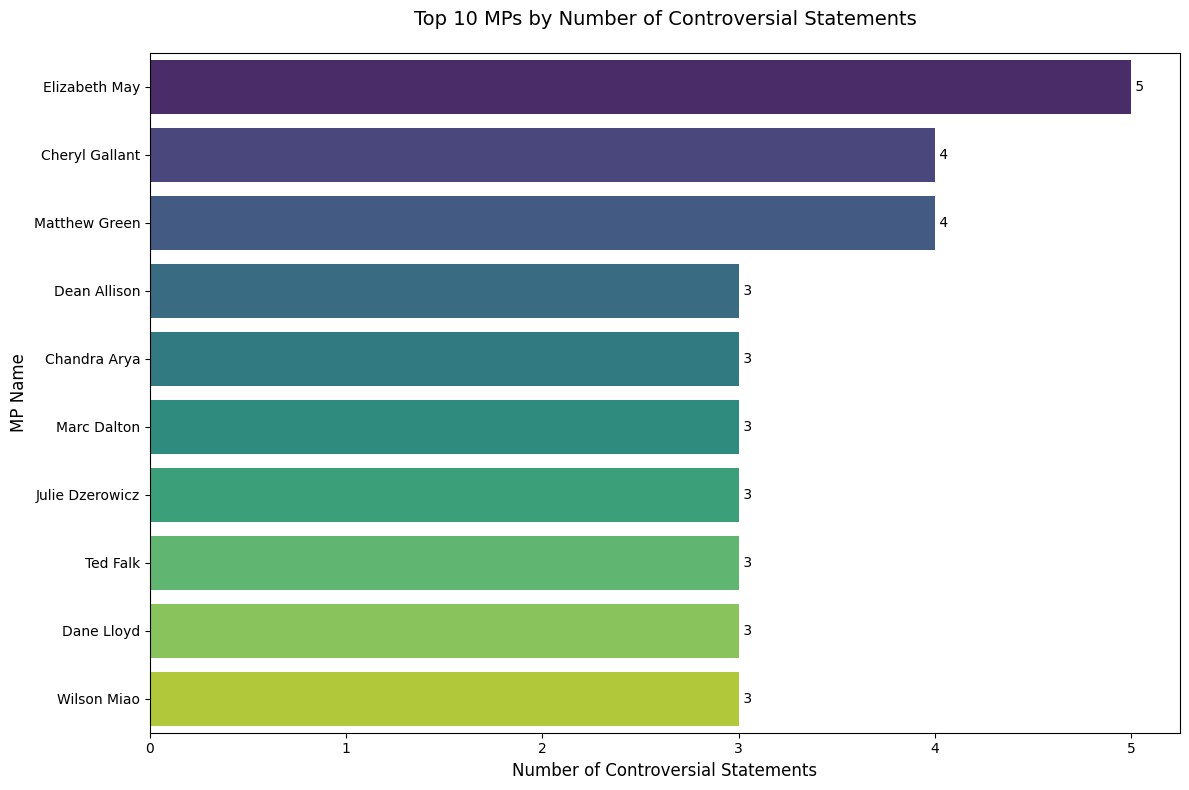


Detailed Controversial Statements for Top 10 MPs:

MP: Elizabeth May
Number of controversial statements: 5
Statements:
1. Comparison of climate change denial to appeasement of Nazis
2. Comments on abortion rights seen as inconsistent
3. Remarks defending Jian Ghomeshi amidst allegations
4. Pseudoscientific views on WiFi and health effects
5. Speech comments about Omar Khadr at a press gallery dinner
--------------------------------------------------------------------------------

MP: Cheryl Gallant
Number of controversial statements: 4
Statements:
1. Made anti-gay remarks to then Foreign Affairs Minister Bill Graham
2. Compared abortion to the beheading of Iraq War hostage Nick Berg
3. Suggested Liberals wanted to “normalize sexual activity with children”
4. Accused Prime Minister Trudeau's gang of pulling off 'false flag operations' during the Freedom Convoy
--------------------------------------------------------------------------------

MP: Matthew Green
Number of controversial sta

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_most_controversial_mps(df, top_n=10, figsize=(12, 8)):
    """
    Create a bar chart of MPs with the most controversial statements.

    Parameters:
    df (pandas.DataFrame): DataFrame containing MP information
    top_n (int): Number of top MPs to display
    figsize (tuple): Figure size (width, height)
    """
    # Create a function to count statements
    def count_statements(statements):
        if pd.isna(statements):
            return 0
        return len([s for s in statements.split(';') if s.strip()])

    # Create a copy of the DataFrame with the count of controversial statements
    analysis_df = df.copy()
    analysis_df['controversy_count'] = analysis_df['controversial_statements'].apply(count_statements)

    # Sort by number of controversial statements
    top_controversial = analysis_df.nlargest(top_n, 'controversy_count')

    # Create labels for MPs (First Name + Last Name)
    mp_labels = top_controversial['First Name'] + ' ' + top_controversial['Last Name']

    # Create the plot
    plt.figure(figsize=figsize)
    bars = sns.barplot(x=top_controversial['controversy_count'],
                      y=mp_labels,
                      palette='viridis')

    # Customize the plot
    plt.title(f'Top {top_n} MPs by Number of Controversial Statements', pad=20, fontsize=14)
    plt.xlabel('Number of Controversial Statements', fontsize=12)
    plt.ylabel('MP Name', fontsize=12)

    # Add value labels on the bars
    for i, v in enumerate(top_controversial['controversy_count']):
        plt.text(v, i, f' {v}', va='center')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed information about each MP's controversial statements
    print(f"\nDetailed Controversial Statements for Top {top_n} MPs:")
    print("=" * 80)
    for _, row in top_controversial.iterrows():
        print(f"\nMP: {row['First Name']} {row['Last Name']}")
        print(f"Number of controversial statements: {row['controversy_count']}")
        print("Statements:")
        if pd.notna(row['controversial_statements']):
            for i, statement in enumerate(row['controversial_statements'].split(';'), 1):
                if statement.strip():
                    print(f"{i}. {statement.strip()}")
        print("-" * 80)

    # Print summary statistics
    total_mps_with_controversies = len(analysis_df[analysis_df['controversy_count'] > 0])
    print(f"\nSummary Statistics:")
    print(f"Total MPs with controversial statements: {total_mps_with_controversies}")
    print(f"Average number of controversial statements per MP: {analysis_df['controversy_count'].mean():.2f}")
    print(f"Maximum number of controversial statements: {analysis_df['controversy_count'].max()}")

    return top_controversial[['First Name', 'Last Name', 'controversy_count', 'controversial_statements']]

# Example usage:
controversial_mps = plot_most_controversial_mps(updated_df)

# Or with custom parameters:
# controversial_mps = plot_most_controversial_mps(df,
#                                               top_n=15,  # Show top 15 MPs
#                                               figsize=(15, 10))  # Larger figure size